__Naive Asymmetry Generator__

Generates a score more naively does not center the image and instead of looking at centroid asymmetry and axis based reflection in this capacity it takes a binary approach to detecting whether the skin itself is more irregeular. Example Usage is down the bottom of the first code cell. Afterwards their is another code cell for a data loader where file paths are needed to be updated on your machine to run

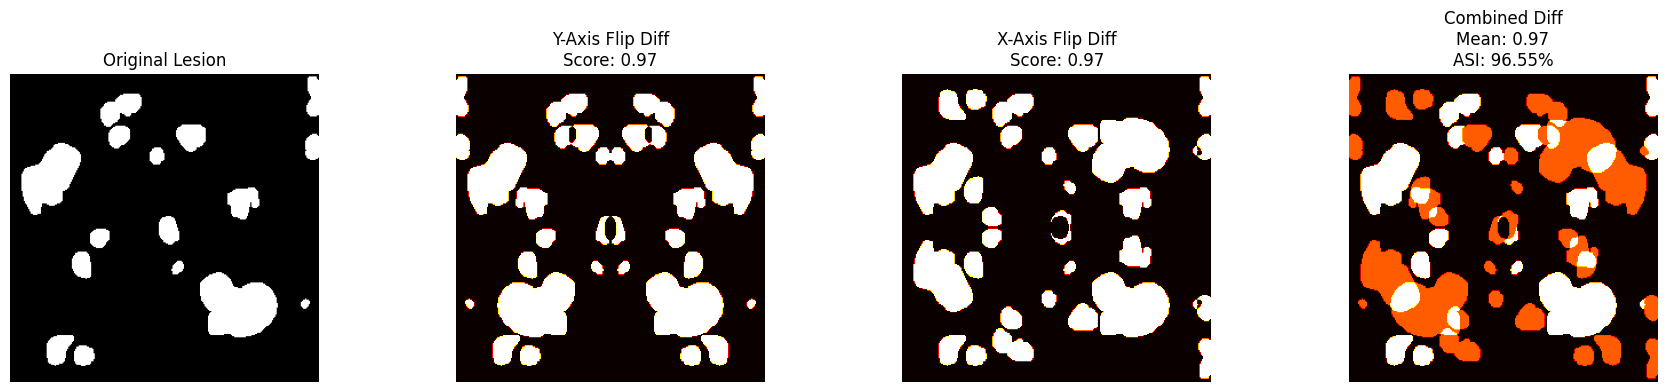

Mean Asymmetry Score: 0.9662
Asymmetry Index (ASI): 96.55%


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

class AsymmetryDetector:
    def __init__(self, image_path):
        self.image_path = image_path
        self.binary_mask = self._load_binary_mask()
        self.binary_mask = self._center_crop(self.binary_mask)
        

    def _load_binary_mask(self):
        """Load a binary mask image."""
        img = cv2.imread(self.image_path, cv2.IMREAD_GRAYSCALE)
        _, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
        return binary

    def _center_crop(self, image):
        """Crop image to have even dimensions for symmetry operations."""
        h, w = image.shape
        if h % 2 != 0:
            image = image[:-1, :]
        if w % 2 != 0:
            image = image[:, :-1]
        return image
    
    def compute_asi(self):
        """Compute Asymmetry Index (ASI) using vertical (Y-axis) reflection."""
        mask = self.binary_mask.astype(np.float32)
        h, w = mask.shape
        mid_x = w // 2

        # Split the mask into left and right halves
        left = mask[:, :mid_x]
        right = mask[:, mid_x:]

        # Flip the right half horizontally
        right_flipped = np.fliplr(right)

        # Resize smaller half if needed
        if left.shape[1] != right_flipped.shape[1]:
            diff = abs(left.shape[1] - right_flipped.shape[1])
            if left.shape[1] > right_flipped.shape[1]:
                right_flipped = np.pad(right_flipped, ((0, 0), (0, diff)), mode='constant')
            else:
                left = np.pad(left, ((0, 0), (0, diff)), mode='constant')

        # Absolute pixel difference
        diff_mask = np.abs(left - right_flipped)

        delta_area = np.sum(diff_mask)
        lesion_area = np.sum(mask) + 1e-5  # total lesion area in 0/1 space

        asi = (delta_area / lesion_area) * 100
        return asi


    def compute_asymmetry_scores(self):
        """Compute asymmetry scores by comparing image flips (binary mask in 0/1)."""
        mask = self.binary_mask.astype(np.float32)  # Ensure float for safe subtraction

        flip_y = np.fliplr(mask)
        flip_x = np.flipud(mask)

        diff_y = np.abs(mask - flip_y)
        diff_x = np.abs(mask - flip_x)

        total_area = np.sum(mask) + 1e-5  # Avoid divide by zero
        score_y = np.sum(diff_y) / (2 * total_area)
        score_x = np.sum(diff_x) / (2 * total_area)

        mean_score = (score_y + score_x) / 2
        return score_y, score_x, mean_score, diff_y, diff_x


    def visualize_asymmetry(self):
        """Visualize the binary mask and its symmetry differences."""
        score_y, score_x, mean_score, diff_y, diff_x = self.compute_asymmetry_scores()
        asi_score = self.compute_asi()

        fig, ax = plt.subplots(1, 4, figsize=(18, 4))
        ax[0].imshow(self.binary_mask, cmap='gray')
        ax[0].set_title("Original Lesion")
        ax[1].imshow(diff_y * 255, cmap='hot')  # scale to 0–255 for visualization
        ax[1].set_title(f"Y-Axis Flip Diff\nScore: {score_y:.2f}")
        ax[2].imshow(diff_x * 255, cmap='hot')  # scale to 0–255 for visualization
        ax[2].set_title(f"X-Axis Flip Diff\nScore: {score_x:.2f}")
        ax[3].imshow(((diff_y + diff_x) / 2) * 255, cmap='hot')  # Combined difference
        ax[3].set_title(f"Combined Diff\nMean: {mean_score:.2f}\nASI: {asi_score:.2f}%")
        for a in ax:
            a.axis('off')
        plt.tight_layout()
        plt.show()

        return mean_score, asi_score


if __name__ == "__main__":
    image_path = r"C:\Users\Peter\Documents\Data Science\Semester 2 - Projects in Data Science\FinalData\padchest_lesion_masks\lesion_masks\PAT_93_361_51_mask.png"
    detector = AsymmetryDetector(image_path)
    mean_score, asi_score = detector.visualize_asymmetry()
    print(f"Mean Asymmetry Score: {mean_score:.4f}")
    print(f"Asymmetry Index (ASI): {asi_score:.2f}%")



In [4]:
import os
import pandas as pd
# If this class is in a separate file, adjust the import accordingly

# --- Paths ---
csv_path = r"C:\Users\Peter\Documents\Data Science\Semester 2 - Projects in Data Science\FinalData\padchest_lesion_masks\metadata_clean_valid_mask_only.csv"
image_dir = r"C:\Users\Peter\Documents\Data Science\Semester 2 - Projects in Data Science\FinalData\padchest_lesion_masks\lesion_masks"
output_csv = r"C:\Users\Peter\Documents\Data Science\Semester 2 - Projects in Data Science\FinalData\ass_scores_center_corrected.csv"

# --- Load CSV ---
df = pd.read_csv(csv_path)

# --- Helper: Clean image id and form file path ---
def get_mask_path(img_id, folder):
    base = os.path.splitext(img_id)[0]
    return os.path.join(folder, f"{base}_mask.png")

# --- Process Images ---
results = []

for img_id in df['img_id']:
    mask_path = get_mask_path(img_id, image_dir)
    if os.path.exists(mask_path):
        try:
            detector = AsymmetryDetector(mask_path)
            _, _, mean_score, _, _ = detector.compute_asymmetry_scores()
            asi_score = detector.compute_asi()

            results.append({"img_id": img_id, "asymmetry_score": mean_score, "asymmetry_index": asi_score})
        except Exception as e:
            print(f"❌ Error processing {img_id}: {e}")
    else:
        print(f"⚠️ Missing file: {mask_path}")

# --- Save to CSV ---
result_df = pd.DataFrame(results)
result_df.to_csv(output_csv, index=False)